In [22]:
try :
    import pandas as pd
    import numpy as np
    import math
    import matplotlib.pyplot as plt # Visualization
    import matplotlib.dates as mdates # Formatting dates
    import seaborn as sns # Visualization
    from sklearn.preprocessing import MinMaxScaler
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    import torch.optim as optim
    from torch.utils.data import Dataset, DataLoader

    from influxdb_client import InfluxDBClient, Point, Dialect
    from influxdb_client.client.write_api import ASYNCHRONOUS
    import paho.mqtt.client as mqtt
    import time
    import json
    import requests
    import time
    import pytz
    import os
    from datetime import datetime

except ImportError :
    !pip install influxdb-client paho-mqtt
    from influxdb_client import InfluxDBClient, Point, Dialect
    from influxdb_client.client.write_api import ASYNCHRONOUS
    import paho.mqtt.client as mqtt


device = "cuda" if torch.cuda.is_available() else "cpu"

# InfluxDB configuration
BUCKET = 'fullstack-influxdb' #  bucket is a named location where time series data is stored.
url = 'https://iot-group2-service1.iotcloudserve.net/'
token ='Dwj0HPIYScc1zvkB0zHpjxIVIssU_z_-unniio7sOcZl135FZ40ONj9ZX6jgiBWqkwpOQegRAL21Ix1z86SBJw=='
org = 'Chulalongkorn'

# Define functions

In [23]:
def get_df_from_db():

    client = InfluxDBClient(
        url= url,
        token= token,
        org= 'Chulalongkorn'
    )

    write_api = client.write_api()
    query_api = client.query_api()

    query2 = 'from(bucket: "fullstack-influxdb")\
        |> range(start: -7d) \
        |> filter(fn: (r) => r._measurement == "sensor_data")\
        |> filter(fn: (r) => r._field == "humid_sht4x" or r._field == "pressure_bmp280" or r._field == "temp_bmp280" or r._field == "temp_sht4x")\
        |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")'

    csv_result = query_api.query_csv(
        query2,
        dialect=Dialect(
            header=False,
            delimiter=",",
            comment_prefix="#",
            annotations=[],
            date_time_format="RFC3339"
        )
    )

    df = pd.DataFrame(csv_result)

    client.close()

    return df

In [24]:
def format_df(df):

    columns_to_keep = [5, 7, 8, 9, 10]
    df = df[df.columns[columns_to_keep]]

    new_column_names = ['time', 'humid_sht4x', 'pressure_bmp280', 'temp_bmp280', 'temp_sht4x']
    df = df.rename(columns=dict(zip(df.columns, new_column_names)), inplace=False)

    #df['time'] = pd.to_datetime(df['time']).dt.strftime('%Y-%m-%d %H:%M:%S')

    # Convert 'time' column to datetime format
    df['time'] = pd.to_datetime(df['time'])

    # Convert 'time' column to Thailand timezone
    thailand_tz = pytz.timezone('Asia/Bangkok')
    df['time'] = df['time'].dt.tz_convert(thailand_tz)

    # Format 'time' column as desired
    df['time'] = df['time'].dt.strftime('%Y/%m/%d %H:%M:%S')

    df = df.rename(columns={'time': 'Date'})
    df.set_index('Date', inplace=True)

    return df

In [25]:
def prepare_data(df):
    # Setting 80 percent data for training
    split_idx = math.ceil(len(df) * .8)

    # Splitting the dataset
    train_data = df[:split_idx]
    test_data = df[split_idx:]

    # Select only temperature column
    train_data = train_data.iloc[:, 2:3]
    test_data = test_data.iloc[:, 2:3]

    dataset_train = train_data.temp_bmp280.values
    # Reshaping 1D to 2D array
    dataset_train = np.reshape(dataset_train, (-1,1))

    dataset_test = test_data.temp_bmp280.values
    # Reshaping 1D to 2D array
    dataset_test = np.reshape(dataset_test, (-1,1))

    from sklearn.preprocessing import MinMaxScaler

    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_train = scaler.fit_transform(dataset_train)
    scaled_test = scaler.fit_transform(dataset_test)

    sequence_length = 30 # Number of time steps to look back
    X_train, y_train = [], []

    for i in range(len(scaled_train) - sequence_length):
        X_train.append(scaled_train[i:i+sequence_length])
        y_train.append(scaled_train[i+1:i+sequence_length+1])

    X_train, y_train = np.array(X_train), np.array(y_train)

    # Convert data to PyTorch tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.float32)

    sequence_length = 30 # Number of time steps to look back
    X_test, y_test = [], []

    for i in range(len(scaled_test) - sequence_length):
        X_test.append(scaled_test[i:i+sequence_length])
        y_test.append(scaled_test[i+1:i+sequence_length+1])

    X_test, y_test = np.array(X_test), np.array(y_test)

    # Convert data to PyTorch tensors
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.float32)

    return train_data, test_data, X_train, y_train, X_test, y_test, scaler


In [26]:
def create_model():

    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size, num_layers):
            super(LSTMModel, self).__init__() #initializes the parent class nn.Module
            self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
            self.linear = nn.Linear(hidden_size, 1)

        def forward(self, x):
            out, _ = self.lstm(x)
            out = self.linear(out)
            return out

    input_size = 1
    num_layers = 2
    hidden_size = 64
    output_size = 1

    model = LSTMModel(input_size, hidden_size, num_layers).to(device)

    return model

In [27]:
def train_model(model, X_train, y_train, X_test, y_test):

    batch_size = 16

    # Create DataLoader for train dataset
    train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Create DataLoader for test dataset
    test_dataset = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    loss_fn = torch.nn.MSELoss(reduction='mean')

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    from tqdm.auto import tqdm

    num_epochs = 5
    train_hist =[]
    test_hist =[]

    # Training loop
    for epoch in tqdm(range(num_epochs)):
        total_loss = 0.0

        # Training
        model.train()
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            predictions = model(batch_X)

            loss = loss_fn(predictions, batch_y)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            total_loss += loss.item()

        # Calculate average training loss and accuracy
        average_loss = total_loss / len(train_loader)
        train_hist.append(average_loss)

        # Validation on test data
        model.eval()
        with torch.no_grad():
            total_test_loss = 0.0

            for batch_X_test, batch_y_test in test_loader:
                batch_X_test, batch_y_test = batch_X_test.to(device), batch_y_test.to(device)
                predictions_test = model(batch_X_test)
                test_loss = loss_fn(predictions_test, batch_y_test)

                total_test_loss += test_loss.item()

            # Calculate average test loss and accuracy
            average_test_loss = total_test_loss / len(test_loader)
            test_hist.append(average_test_loss)
        if (epoch + 1) % 1 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}] - Training Loss: {average_loss:.4f}, Test Loss: {average_test_loss:.4f}')

    x = np.linspace(1,num_epochs,num_epochs)
    plt.plot(x,train_hist,scalex=True, label="Training loss")
    plt.plot(x, test_hist, label="Test loss")
    plt.legend()
    plt.show()


In [69]:
def predict(device, model, test_data, X_train, y_train, X_test, y_test, scaler):

    num_forecast_steps = 30

    # Convert to NumPy and remove singleton dimensions
    sequence_to_plot = X_test.squeeze().cpu().numpy()

    # Use the last 30 data points as the starting point
    historical_data = sequence_to_plot[-1]
    #print(historical_data.shape)

    # Initialize a list to store the forecasted values
    forecasted_values = []

    # Use the trained model to forecast future values
    with torch.no_grad():
        for _ in range(num_forecast_steps * 2):

            # Prepare the historical_data tensor
            historical_data_tensor = torch.as_tensor(historical_data).view(1, -1, 1).float().to(device)

            # Use the model to predict the next value
            predicted_value = model(historical_data_tensor).cpu().numpy()[0, 0]

            # Append the predicted value to the forecasted_values list
            forecasted_values.append(predicted_value[0])

            # Update the historical_data sequence by removing the oldest value and adding the predicted value
            historical_data = np.roll(historical_data, shift=-1)
            historical_data[-1] = predicted_value

    # Generate futute dates
    last_date = test_data.index[-1]
    last_date = pd.to_datetime(last_date)

    # Generate the next 30 dates
    future_dates = pd.date_range(start=last_date + pd.DateOffset(1), periods=30)

    # Concatenate the original index with the future dates
    combined_index = test_data.index.append(future_dates)
    original_cases = scaler.inverse_transform(np.expand_dims(sequence_to_plot[-1], axis=0)).flatten()
    forecasted_cases = scaler.inverse_transform(np.expand_dims(forecasted_values, axis=0)).flatten()

    time_to_db = combined_index[-60:]

    x = test_data.index[-200:-30].tolist()
    y_test = [float(x) for x in test_data.temp_bmp280[-200:-30].tolist()]

    new_x = []
    count = 0

    for i in test_data.index[-200:-30].tolist() :
        if len(new_x) == 0 :
            new_x.append(i[11:-3])
        else:
            last_new_x = new_x[len(new_x)+count-1]
            hrs = int(last_new_x[:2])
            min = int(last_new_x[3:])

            if min==59 and int(i[11:13])==hrs+1 and int(i[14:16])==0 :
                new_x.append(i[11:-3])
                count = 0
            elif min!=59 and int(i[11:13])==hrs and int(i[14:16])==min+1 :
                new_x.append(i[11:-3])
                count = 0
            else:
                new_x.append('')
                count -= 1

    new_x[0] = ''

    y_test = [float(x) for x in test_data.temp_bmp280[-200:-30].tolist()][:128]

    l1 = []
    count = 0

    for i in test_data.index[-200:-30].tolist()[129:] :
        if len(l1) == 0 :
            l1.append(i[11:-3])
        else:
            last_l1 = l1[len(l1)+count-1]
            hrs = int(last_l1[:2])
            min = int(last_l1[3:])

            if min==59 and int(i[11:13])==hrs+1 and int(i[14:16])==0 :
                l1.append(i[11:-3])
                count = 0
            elif min!=59 and int(i[11:13])==hrs and int(i[14:16])==min+1 :
                l1.append(i[11:-3])
                count = 0
            else:
                l1.append('')
                count -= 1

    l1[0] = ''

    l2 = []
    count = 0

    for i in combined_index[-60:].astype(str).tolist() :
        if len(l2) == 0 :
            l2.append(i[11:-3])
        else:
            last_l2 = l2[len(l2)+count-1]
            hrs = int(last_l2[:2])
            min = int(last_l2[3:])

            if min==59 and int(i[11:13])==hrs+1 and int(i[14:16])==0 :
                l2.append(i[11:-3])
                count = 0
            elif min!=59 and int(i[11:13])==hrs and int(i[14:16])==min+1 :
                l2.append(i[11:-3])
                count = 0
            else:
                l2.append('')
                count -= 1

    l2[0] = ''

    x_act_fore = l1+l2

    y_test = [float(x) for x in test_data.temp_bmp280[-200:-30].tolist()][129:]
    y_act = [float(x) for x in original_cases.tolist()]
    y_fore = [float(x) for x in forecasted_cases.tolist()]

    plt.plot([i for i in range(len(y_test))], y_test, label='test data', color='b')
    plt.plot([i for i in range(40, len(y_act)+40)], y_act, label='actual values', color='green')
    plt.plot([i for i in range(40, len(y_fore)+40)], y_fore, label='forecasted values', color='red')

    plt.xlabel('Time Step')
    plt.xticks([i for i in range(101)], x_act_fore)
    plt.ylabel('Value')

    plt.legend()
    plt.title('2024-05-12')
    plt.grid(True)
    plt.show()

    df_to_db = pd.DataFrame(y_fore, time_to_db)
    df_to_db.reset_index(inplace=True)
    df_to_db.columns = ['time', 'val']
    df_to_db['time'] = df_to_db['time'].apply(lambda x: datetime.strptime(x, "%Y/%m/%d %H:%M:%S").strftime("%Y-%m-%dT%H:%M:%S.%fZ") if isinstance(x, str) else x.strftime("%Y-%m-%dT%H:%M:%S.%fZ"))

    client = InfluxDBClient(
        url= url,
        token= token,
        org= 'Chulalongkorn'
    )

    write_api = client.write_api()

    for index, row in df_to_db.iterrows():


        point = Point("prediction_data")\
            .field("try8", row['val'])
        write_api.write(BUCKET, org, point)

    print("Finished writing this data")

    #client.close()



# Periodic prediction and training

*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


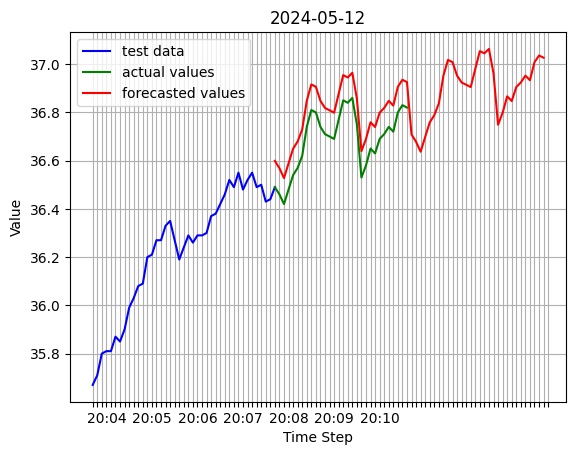

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


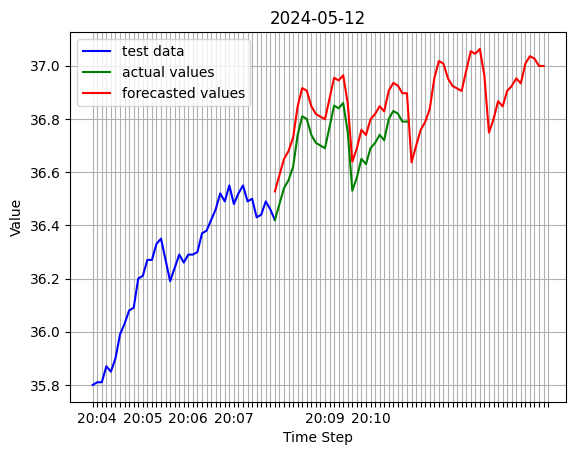

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


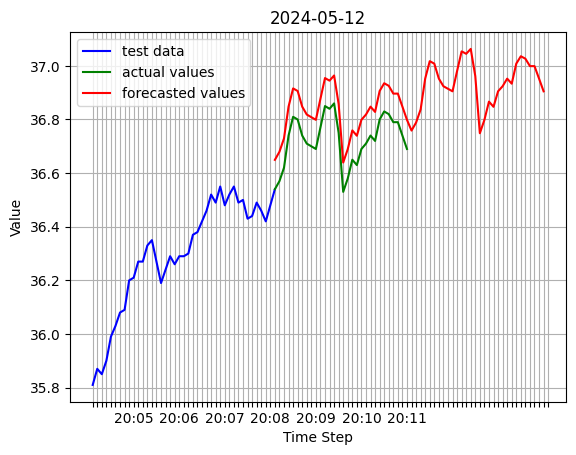

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


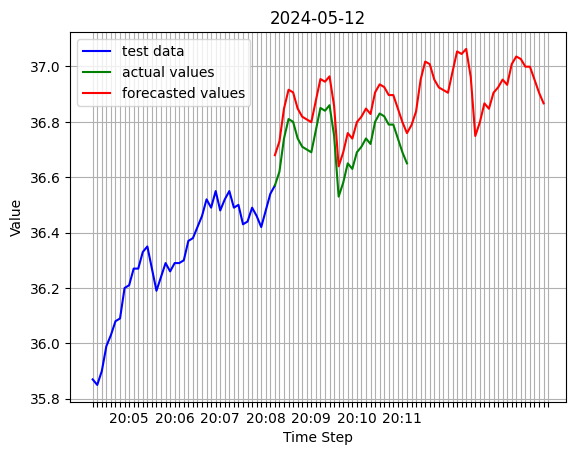

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


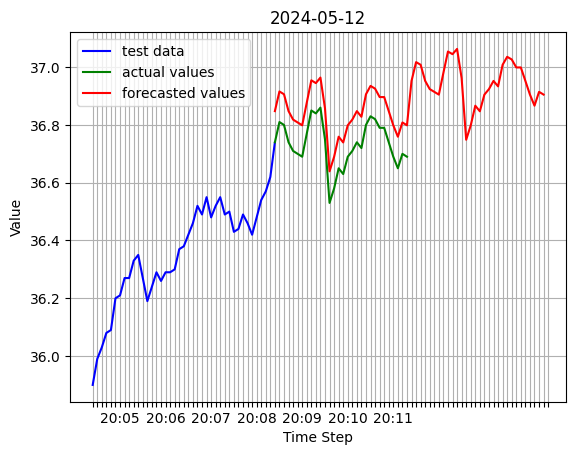

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


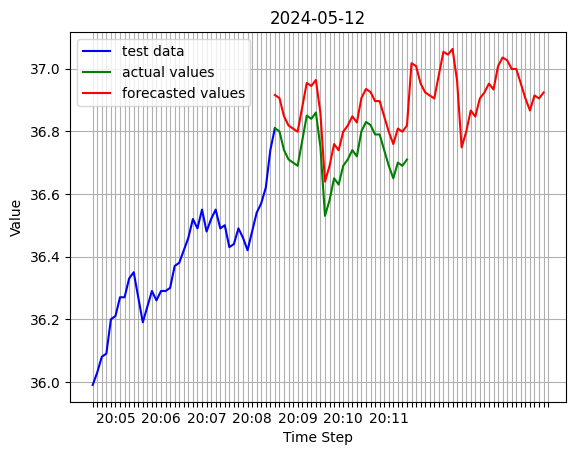

Finished writing this data
*****Finished prediction*****


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5] - Training Loss: 0.0002, Test Loss: 0.0009
Epoch [2/5] - Training Loss: 0.0002, Test Loss: 0.0011
Epoch [3/5] - Training Loss: 0.0002, Test Loss: 0.0010
Epoch [4/5] - Training Loss: 0.0002, Test Loss: 0.0010
Epoch [5/5] - Training Loss: 0.0002, Test Loss: 0.0010


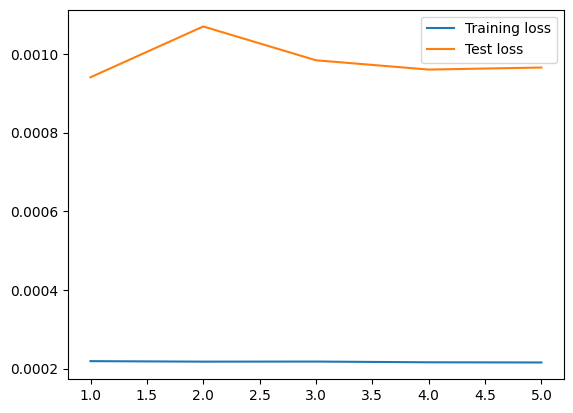

*****Finished training*****
*****Saved the model weights*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


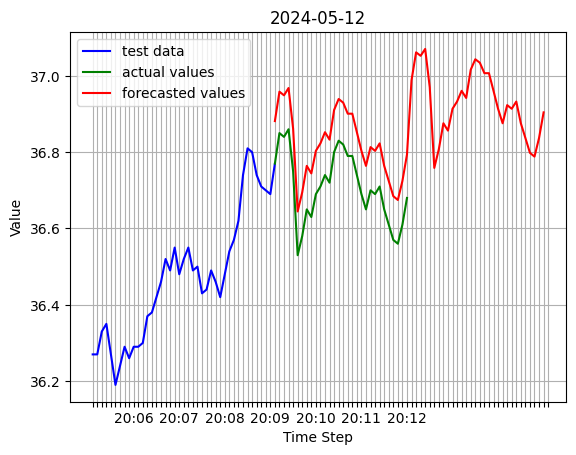

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


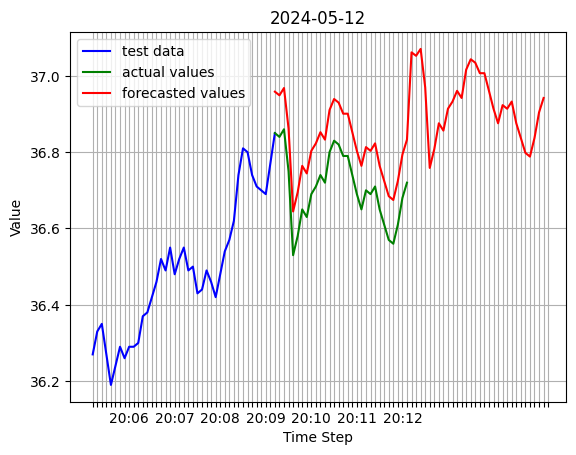

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


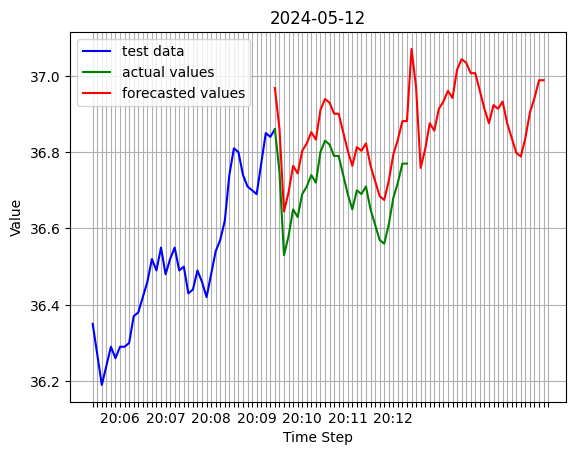

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


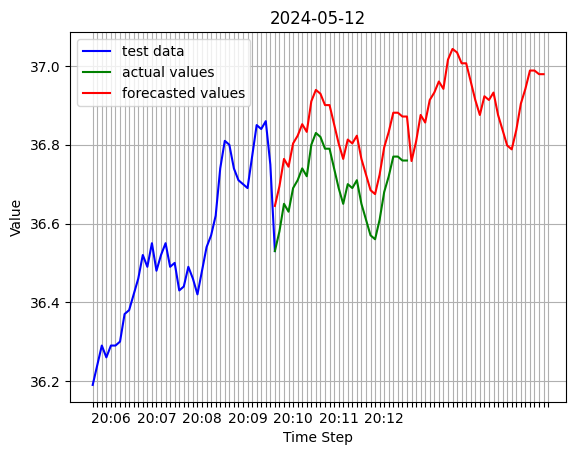

Finished writing this data
*****Finished prediction*****


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch [1/5] - Training Loss: 0.0002, Test Loss: 0.0009
Epoch [2/5] - Training Loss: 0.0002, Test Loss: 0.0010
Epoch [3/5] - Training Loss: 0.0002, Test Loss: 0.0010
Epoch [4/5] - Training Loss: 0.0002, Test Loss: 0.0010
Epoch [5/5] - Training Loss: 0.0002, Test Loss: 0.0010


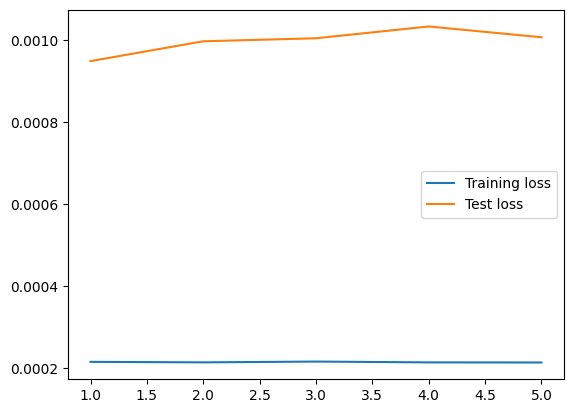

*****Finished training*****
*****Saved the model weights*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


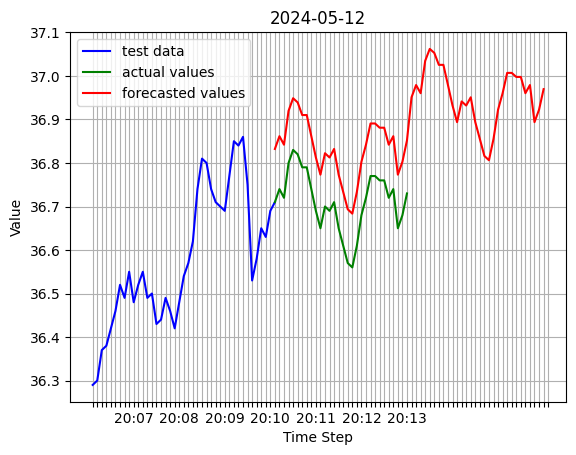

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


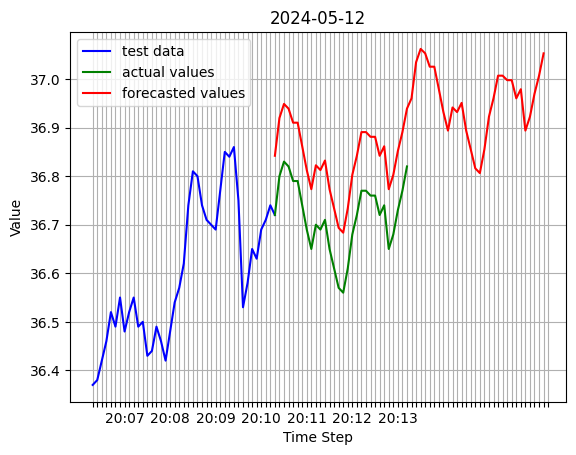

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


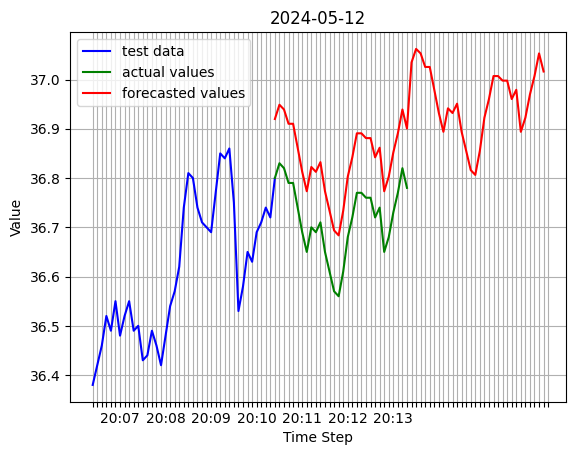

Finished writing this data
*****Finished prediction*****
*****The queried dataframe is ready*****
*****Data is formatted*****
*****Data is ready*****
*****Loaded the existing model weights*****


<ipython-input-69-4a034fae0e39>:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  historical_data[-1] = predicted_value


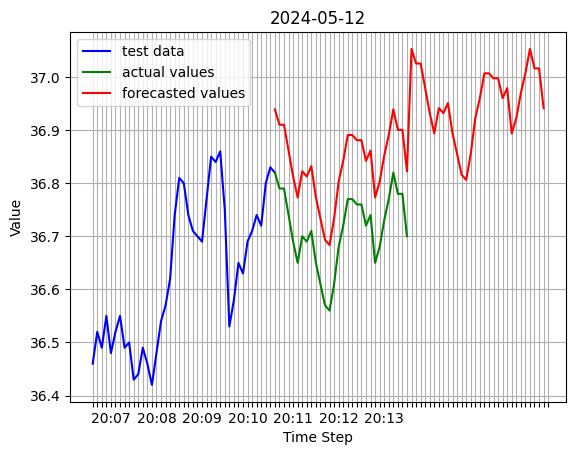

Finished writing this data
*****Finished prediction*****


KeyboardInterrupt: 

In [70]:
import time

last_train_time = time.time()

while True :

    df = get_df_from_db()
    print("*****The queried dataframe is ready*****")

    df = format_df(df)
    print("*****Data is formatted*****")

    train_data, test_data, X_train, y_train, X_test, y_test, scaler = prepare_data(df)
    print("*****Data is ready*****")

    model_path = "model.pth"

    model = create_model()
    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        print("*****Loaded the existing model weights*****")
    else:
        print("*****Created a new model*****")

    predict(device, model, test_data, X_train, y_train, X_test, y_test, scaler)
    print("*****Finished prediction*****")
    time.sleep(6)

    current_time = time.time()
    if current_time - last_train_time >= 60:

        train_model(model, X_train, y_train, X_test, y_test)
        print("*****Finished training*****")

        torch.save(model.state_dict(), model_path)
        print("*****Saved the model weights*****")
        last_train_time = current_time
